# Is carpooling a good idea in Chicago?


## Introduction
Carpool is the sharing of car journeys, which are mainly provided by the rider sharing compenies. Usually, the platform finds the match for the riders with sharing authorization.I want to evaluate the performance of carpooling, so that the riders may have a better understanding on carpooling and make trade off between time and cost. The topic is intersting for both riders and ride-sharing companies.

## Data import
I use the trip data from the Chicago data portal(https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p). It contains all trips reported by the transportation service provider, including Uber, Lyft and Via, starting from Nov 2018. The data records the start/end time, trip distance, trip time, orgin, destination, fare, and carpooling info for each trip. In particular, it records how many riders carpool a trip. I download the 11gb csv file with 45.3M rows and 21 columns. Due to memory size limit, I read it in chunks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
reader = pd.read_csv('D:\DS\Trips.csv',parse_dates=['Trip Start Timestamp','Trip End Timestamp'],chunksize=1_000_000)

([<matplotlib.patches.Wedge at 0xa972b38>,
 [Text(-0.6606881955361712, -1.0017440333134797, 'No-sharing'),
  Text(0.8474477702467821, 0.7013075478730838, '2'),
  Text(0.3981757636364044, 1.0254053155960166, '3'),
  Text(0.08128249189824048, 1.0969927786958364, '>3')],
 [Text(-0.3854014473960998, -0.5843506860995298, '81.4%'),
  Text(0.4622442383164265, 0.38253138974895473, '9.1%'),
  Text(0.21718678016531145, 0.5593119903250999, '7.1%'),
  Text(0.044335904671767526, 0.5983596974704563, '2.4%')])

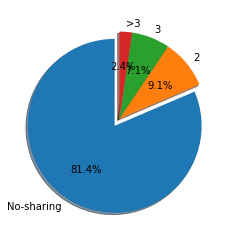

In [63]:
c = np.zeros(4)
for ck in reader:
    tc = np.histogram(ck['Trips Pooled'], bins=[1,2,3,4,5])
    c = c + tc[0]

plt.pie(c, explode=(0.1, 0, 0, 0), labels=('No-sharing', '2', '3', '>3'), autopct='%1.1f%%',
        shadow=True, startangle=90)

Most of trips are not shared. Very few trips are shared by 3+ riders! 

### Sampling
I want to make sure there are sufficient number of obs in each group, set sample size at 5% of the whole population, roughly 2.2M records.

In [77]:
Sam = pd.DataFrame()
for ck in reader:
    t = ck.sample(n=50_000)
    Sam = pd.concat([Sam,t])
Sam.to_csv('D:\DS\Tsample.csv')

In [2]:
Sam = pd.read_csv('D:\DS\Tsample.csv',parse_dates=['Trip Start Timestamp','Trip End Timestamp'])

In [23]:
Sam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250000 entries, 0 to 2249999
Data columns (total 22 columns):
Unnamed: 0                    int64
Trip ID                       object
Trip Start Timestamp          datetime64[ns]
Trip End Timestamp            datetime64[ns]
Trip Seconds                  float64
Trip Miles                    float64
Pickup Census Tract           float64
Dropoff Census Tract          float64
Pickup Community Area         float64
Dropoff Community Area        float64
Fare                          float64
Tip                           float64
Additional Charges            float64
Trip Total                    float64
Shared Trip Authorized        bool
Trips Pooled                  int64
Pickup Centroid Latitude      float64
Pickup Centroid Longitude     float64
Pickup Centroid Location      object
Dropoff Centroid Latitude     float64
Dropoff Centroid Longitude    float64
Dropoff Centroid Location     object
dtypes: bool(1), datetime64[ns](2), float64(14)

In [35]:
Sam[['Trip Miles','Trip Seconds','Trips Pooled']].describe()

,Trip Miles,Trip Seconds,Trips Pooled
count,2.249999e+06,2.249818e+06,2.250000e+06
mean,5.872101e+00,1.055296e+03,1.332395e+00
std,6.562142e+00,7.535146e+02,8.113163e-01
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.800000e+00,5.240000e+02,1.000000e+00
50%,3.600000e+00,8.550000e+02,1.000000e+00
75%,7.300000e+00,1.378000e+03,1.000000e+00
max,3.168000e+02,4.710000e+04,1.700000e+01


Restrict the trip distance to 80 miles and travel time to 9000 seconds. Also, I grouped all >3 carpool trips.

In [8]:
da = Sam[(Sam['Trip Seconds']<=9000) & (Sam['Trip Miles']<=80)]
da['pool']=da['Trips Pooled'].apply(lambda x: str(x) if x <= 3 else '>3')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, 'Trip Time')

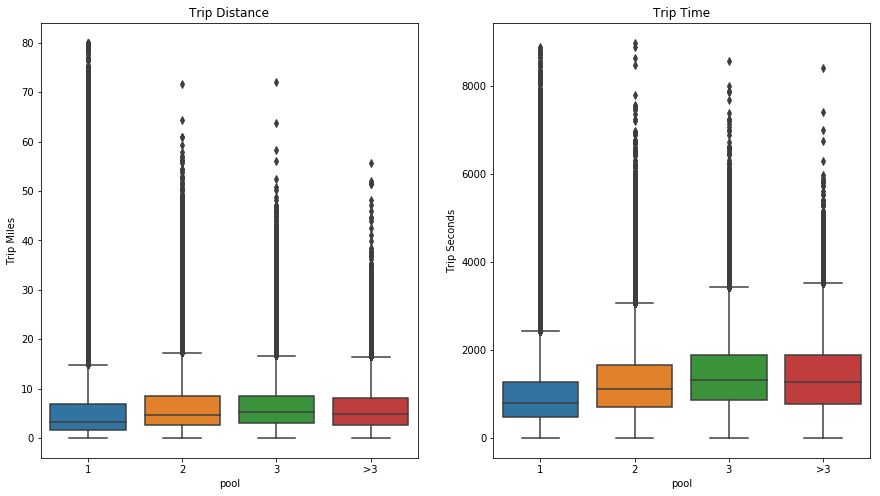

In [25]:
import seaborn as sns

fig, axs = plt.subplots(ncols=2, sharex = True,figsize=(12, 8))
fig.subplots_adjust(hspace=0.5, left=0.07, right=1.03)

sns.boxplot(da['pool'],da['Trip Miles'],order =['1','2','3','>3'],ax=axs[0])
axs[0].set_title("Trip Distance")
sns.boxplot(da['pool'],da['Trip Seconds'],order =['1','2','3','>3'],ax=axs[1])
axs[1].set_title("Trip Time")


On average, non-shared trips have the least trip time and trip distance. Surprisingly, trips with 3 riders have less trip time than trips with more than 3 riders. One possibility is that carpool with more than 3 riders are more likely to be scheduled in advance, so they can save some waiting time and avoid detour. Outlines for very long trips.

'ax = axs[1]\nd = df[df[\'trips_pooled\']==1]\nhb = ax.hexbin(d[\'trip_seconds\'],d[\'trip_miles\'],bins=\'log\',mincnt=4)\nax.set_title("Hexagon binning")\nax.grid(color=\'r\', linestyle=\'--\', linewidth=2,alpha=0.3)\n\n\ncb = fig.colorbar(hb, ax=ax)\ncb.set_label(\'counts\')\n\n\n'

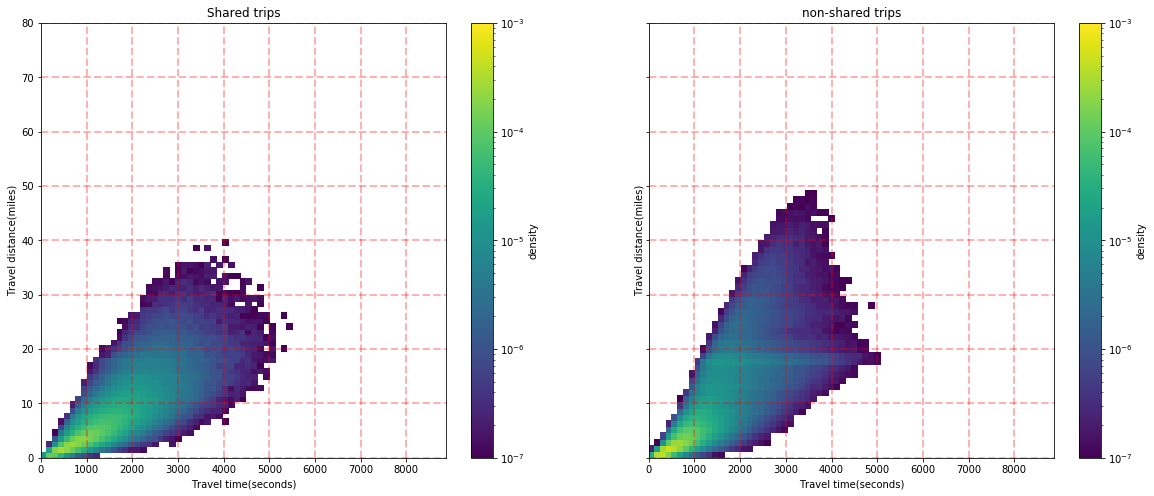

In [17]:
import matplotlib as mpl

fig, axs = plt.subplots(ncols=2, sharex = True,sharey = True,figsize=(18, 8))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)

ax = axs[0]
d = da[da['Trips Pooled']>1]
h = ax.hist2d(d['Trip Seconds'],d['Trip Miles'],vmin=10**-7,vmax=10**-3,norm=mpl.colors.LogNorm(),bins=70,normed=True, cmin=10**-7)
ax.grid(color='r', linestyle='--', linewidth=2,alpha=0.3)
ax.set_title("Shared trips")
ax.set_xlabel('Travel time(seconds)')
ax.set_ylabel('Travel distance(miles)')
cb = fig.colorbar(h[3], ax=ax)
cb.set_label('density')

ax = axs[1]
d = da[da['Trips Pooled']==1]
h = ax.hist2d(d['Trip Seconds'],d['Trip Miles'],vmin=10**-7,vmax=10**-3,bins=70,norm=mpl.colors.LogNorm(),normed=True, cmin=10**-7)
ax.grid(color='r', linestyle='--', linewidth=2,alpha=0.3)
ax.set_title("non-shared trips")
ax.set_xlabel('Travel time(seconds)')
ax.set_ylabel('Travel distance(miles)')
cb = fig.colorbar(h[3], ax=ax)
cb.set_label('density')


#### Notes:
##### 1. minmal density is set to remove very isolated point from the graph.
##### 2. This graph shows the 2-d density of time-distance of trips.
##### 3. Detour is taken into acount.

#### Several observations:
##### 1. Delay from ride-sharing increases with trip distance
For each point, the slope represents the overall traveling speed. There is no significant difference in the overal speed for short distance, i.e., less than 10 miles. Shared trips are slightly slowed down when trip distance is longer. One explanation is that, when trip distance is short, the second(or third, fourth, etc.) rider expects the dirver to come in any minute and prepare for the ride, so the driver's waiting time might be lower.  
##### 2. long-distance trips are mostly not shared
There are not too many long-distance shared trips(> 35 miles). But we do observe some clusters with long distance in non-shared trips.It is somewhat counterintutive, since we normally believe people prefer to share long distance trips than they do for short-distance trips. Maybe they are afraid of the unstable travel time? or maybe there is difficulty finding a match for long-distance trips?


### Long distance trips
Analysis of the long distance trips.

Text(0.5, 1.0, 'All trips')

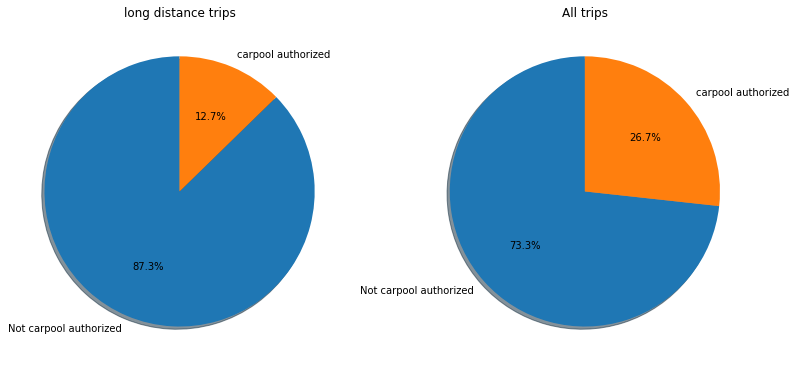

In [57]:
Lond = da[da['Trip Miles']>30]

fig, axs = plt.subplots(ncols=2,figsize=(12, 8))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
d = np.histogram(Lond['Shared Trip Authorized'],bins= [0,1,2])
axs[0].pie(d[0],labels=('Not carpool authorized', 'carpool authorized'), autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0].set_title('long distance trips')

d = np.histogram(da['Shared Trip Authorized'],bins= [0,1,2])
axs[1].pie(d[0],labels=('Not carpool authorized', 'carpool authorized'),autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1].set_title('All trips')




Riders prefer not to share for long distance trips.

### Detour
Notice the trips distance also includes the detour caused by carpooling.

In [82]:
# Calculate the distance
from geopy import distance as dis
da['straight']=da.apply(lambda x:(dis.distance((x['Pickup Centroid Latitude'],x['Pickup Centroid Longitude']),
                                               (x['Dropoff Centroid Latitude'],x['Dropoff Centroid Longitude']))).miles, axis=1)

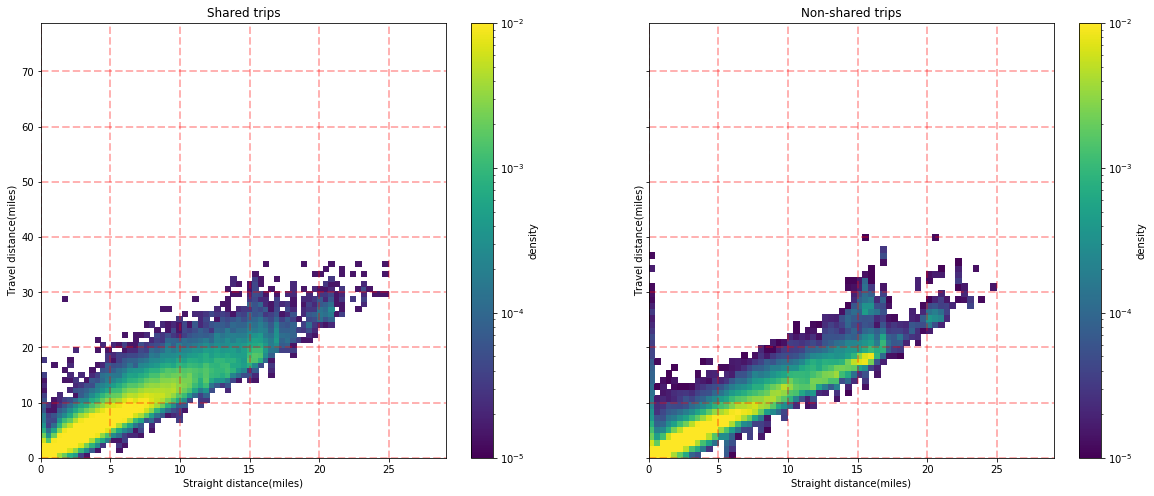

In [89]:
import matplotlib as mpl

fig, axs = plt.subplots(ncols=2, sharex = True,sharey = True,figsize=(18, 8))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)



ax = axs[0]
d = da[da['Trips Pooled']>1]
h = ax.hist2d(d['straight'],d['Trip Miles'],vmin=10**-5,vmax=10**-2,norm=mpl.colors.LogNorm(),bins=70,normed=True, cmin=10**-5)
ax.grid(color='r', linestyle='--', linewidth=2,alpha=0.3)
ax.set_title("Shared trips")
ax.set_xlabel('Straight distance(miles)')
ax.set_ylabel('Travel distance(miles)')
cb = fig.colorbar(h[3], ax=ax)
cb.set_label('density')

ax = axs[1]
d = da[da['Trips Pooled']==1]
h = ax.hist2d(d['straight'],d['Trip Miles'],vmin=10**-5,vmax=10**-2,bins=70,norm=mpl.colors.LogNorm(),normed=True, cmin=10**-5)
ax.grid(color='r', linestyle='--', linewidth=2,alpha=0.3)
ax.set_title("Non-shared trips")
ax.set_xlabel('Straight distance(miles)')
ax.set_ylabel('Travel distance(miles)')
cb = fig.colorbar(h[3], ax=ax)
cb.set_label('density')

In [66]:
import sys
!{sys.executable} -m pip install geopy

  Using cached https://files.pythonhosted.org/packages/75/3e/80bc987e1635ba9e7455b95e233b296c17f3d3bf3d4760fa67cdfc840e84/geopy-1.19.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5b/ac/4f348828091490d77899bc74e92238e2b55c59392f21948f296e94e50e2b/geographiclib-1.49.tar.gz
  Stored in directory: C:\Users\HS\AppData\Local\pip\Cache\wheels\99\45\d1\14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
